In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

import transitions
from collections import deque
import plotly.express as px
from IPython.display import display, Markdown
# display(Markdown(trial_results.to_markdown()))

In [2]:
laser_iv = np.array([3.339754422650176, 1.003425703613611])
laser_li = np.array([0.3061936769909521, -0.0056601769911848775])

In [3]:
def simple_laser(i_drive, tbk, rjc=45, tbk0 = 35, i_drive0=0.14):
    v_drive = laser_iv[0]*i_drive + laser_iv[1]
    ele_power = v_drive*i_drive
    opt_power = i_drive * laser_li[0] + laser_li[1]
    wpe = opt_power/ele_power
    heat_power = ele_power - opt_power
    Tj = tbk + heat_power*rjc
    
    v_drive0 = laser_iv[0]*i_drive0 + laser_iv[1]
    ele_power0 = v_drive0*i_drive0
    opt_power0 = i_drive0 * laser_li[0] + laser_li[1]
    wpe0 = opt_power0/ele_power0
    heat_power0 = ele_power0 - opt_power0
    Tj0 = tbk0 + heat_power0*rjc
    
    delta_T = Tj - Tj0
    delta_lambda = delta_T*0.1e-9
    
    simple_laser_dict = {
        "i_drive": i_drive,
        "v_drive": v_drive,
        "ele_power": ele_power,
        "opt_power": opt_power,
        "heat_power": heat_power,
        "wpe": wpe,
        "heat_power": heat_power,
        "tbk": tbk,
        "Tj": Tj,
        "i_drive0": i_drive0,
        "v_drive0": v_drive0,
        "ele_power0": ele_power0,
        "opt_power0": opt_power0,
        "heat_power0": heat_power0,
        "wpe0": wpe0,
        "heat_power0": heat_power0,
        "tbk0": tbk0,
        "Tj0": Tj0,
        "delta_T": delta_T,
        "delta_lambda": delta_lambda
    }
    return simple_laser_dict

In [4]:
def simple_mux(center_wavelength, laser_wavelength, tbk, mux_bw=0.63e-9, demux_bw = 0.27e-9, ilmux_db=-4.45, ildemux_db = -20.45, tbk0=45):
   delta_T = tbk - tbk0
   delta_lambda = delta_T * 0.01e-9
   ilmux_mag = 10**(ilmux_db/10)
   noise_floor = 10**(-np.random.normal(40, 2, size=len(laser_wavelength))/10)
   ilmux = ilmux_mag*np.exp(-((center_wavelength-laser_wavelength-delta_lambda)/mux_bw)**2/4.343)
   for il_no_a, il_no_b, il_no_c, il_no_d in product(range(ilmux.shape[0]), range(ilmux.shape[1]), range(ilmux.shape[2]), range(ilmux.shape[3])):
      if ilmux[il_no_a, il_no_b, il_no_c, il_no_d] < 10**-5.5:
         ilmux[il_no_a, il_no_b, il_no_c, il_no_d] = 10**(-np.random.normal(50, 2)/10)
   
   ildemux_mag = 10**(ildemux_db/10)
   ildemux = ildemux_mag*np.exp(-((center_wavelength-laser_wavelength-delta_lambda)/demux_bw)**2/4.343)
   for il_no_a, il_no_b, il_no_c, il_no_d in product(range(ildemux.shape[0]), range(ildemux.shape[1]), range(ildemux.shape[2]), range(ildemux.shape[3])):
      if ildemux[il_no_a, il_no_b, il_no_c, il_no_d] < 10**-5.5:
         ildemux[il_no_a, il_no_b, il_no_c, il_no_d] = 10**(-np.random.normal(50, 2)/10)
   
   mux_dict = {
      "center_wavelength": center_wavelength,
      "laser_wavelength": laser_wavelength,
      "mux_bw": mux_bw,
      "ilmux_dB": ilmux_db,
      "ilmux": ilmux,
      "demux_bw": demux_bw,
      "ildemux_dB": ildemux_db,
      "ildemux": ildemux
   }
   return mux_dict

# Case-1: No temperature difference between the MUX and the DFB PIC

In [5]:
'''
1. Set the drive current to 140 mA.
2. DFB PIC nominal back-side temperature to be 35C
3. EBMUX nominal backside 45C
'''

max_temperature_sweep = 70
min_temperature_sweep = 20

drive_current_datapoints = int(1e2+1)
wavelength_datapoints = int(1e3+1)
temperature_datapoints  = (max_temperature_sweep - min_temperature_sweep)*10 + 1
temperature_backside_datapoints = 7

mux_center_wavelength = 1310e-9
laser_center_wavelength = 1310e-9

min_dfb_tbk0 = 35
max_dfb_tbk0 = 55

mux_dfb_temperature_offset = 0

tbk0 = np.sort(np.random.uniform(min_dfb_tbk0, max_dfb_tbk0, temperature_backside_datapoints)).reshape(1, 1, 1, temperature_backside_datapoints)
tbk = np.sort(np.random.uniform(min_temperature_sweep, max_temperature_sweep, temperature_datapoints)).reshape(1, 1, temperature_datapoints, 1)
laser_wavelength_range = np.sort(np.random.uniform(1300, 1320, wavelength_datapoints) * 1e-9).reshape(1, wavelength_datapoints, 1, 1)
i_drive_range = np.sort(np.random.uniform(0.01, 0.2, drive_current_datapoints)).reshape(drive_current_datapoints, 1, 1, 1)

simple_laser_tf = simple_laser(i_drive=i_drive_range, tbk=tbk, tbk0=tbk0)
simple_mux_tf = simple_mux(mux_center_wavelength, laser_wavelength_range, tbk=tbk + mux_dfb_temperature_offset)

arg_nominal_drive_current = np.argmin(np.abs(simple_laser_tf["i_drive"] - 0.14))
output_power_tbk_sweep = simple_laser_tf["opt_power"][arg_nominal_drive_current]
output_wavelength_tbk_sweep = (simple_laser_tf["delta_lambda"][arg_nominal_drive_current] + laser_center_wavelength).reshape(temperature_datapoints, temperature_backside_datapoints)
ebdemux_output_power_tbk_sweep = np.zeros_like(output_wavelength_tbk_sweep)
ebmux_output_power_tbk_sweep = np.zeros_like(output_wavelength_tbk_sweep)
for idd_tbk0, tbk0_value in enumerate(tbk0):
    for idd_no, output_wavelength_tbk_value in enumerate(output_wavelength_tbk_sweep[:, idd_tbk0]):
        ebdemux_output_power_tbk_sweep[idd_no, idd_tbk0] = simple_mux_tf["ildemux"][0,np.argmin(np.abs(simple_mux_tf["laser_wavelength"] - output_wavelength_tbk_value)), idd_no,0]*output_power_tbk_sweep[0,0,0]
        ebmux_output_power_tbk_sweep[idd_no, idd_tbk0] = simple_mux_tf["ilmux"][0,np.argmin(np.abs(simple_mux_tf["laser_wavelength"]- output_wavelength_tbk_value)), idd_no,0]*output_power_tbk_sweep[0,0,0]

In [6]:
output_wavelength_tbk_sweep.shape

(501, 7)

In [7]:
simple_mux_tf["ilmux"].shape

(1, 1001, 501, 1)

In [8]:
ebdemux_output_power_tbk_sweep.shape

(501, 7)

In [9]:
ebmux_output_power_tbk_sweep.shape

(501, 7)

In [10]:
simple_laser_tf["opt_power"][arg_nominal_drive_current].shape

(1, 1, 1)

In [11]:
output_wavelength_tbk_sweep.shape

(501, 7)

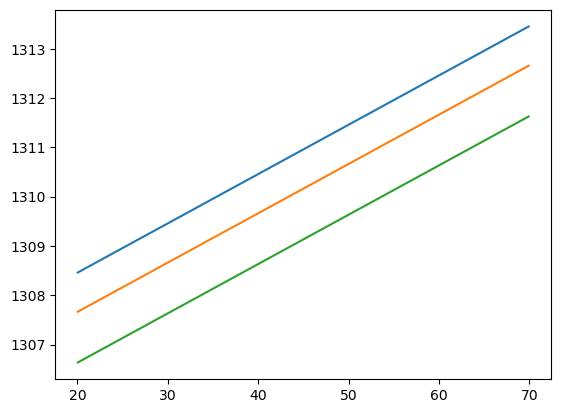

In [13]:
plt.plot(tbk.flatten(), output_wavelength_tbk_sweep[:,0]*1e9)
plt.plot(tbk.flatten(), output_wavelength_tbk_sweep[:,3]*1e9)
plt.plot(tbk.flatten(), output_wavelength_tbk_sweep[:,6]*1e9)

In [14]:
simple_mux_tf["ilmux"].shape

(1, 1001, 501, 1)

In [15]:
simple_mux_tf["laser_wavelength"].shape

(1, 1001, 1, 1)

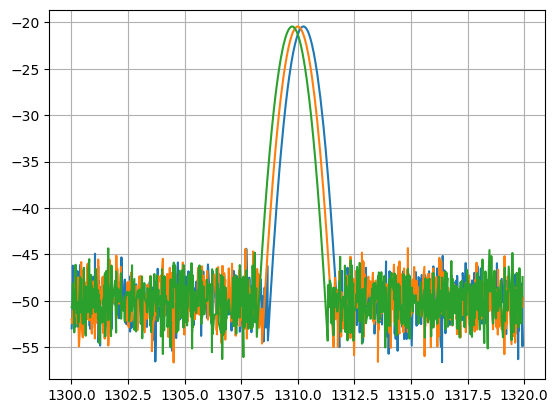

In [16]:
plt.plot(simple_mux_tf["laser_wavelength"].flatten()*1e9, 10*np.log10(simple_mux_tf["ildemux"][0, :, 0, 0]))
plt.plot(simple_mux_tf["laser_wavelength"].flatten()*1e9, 10*np.log10(simple_mux_tf["ildemux"][0, :, 250, 0]))
plt.plot(simple_mux_tf["laser_wavelength"].flatten()*1e9, 10*np.log10(simple_mux_tf["ildemux"][0, :, 500, 0]))
plt.grid(True)

In [17]:
ebdemux_output_power_tbk_sweep.shape

(501, 7)

In [18]:
simple_laser_tf["delta_lambda"][arg_nominal_drive_current].shape

(1, 501, 7)

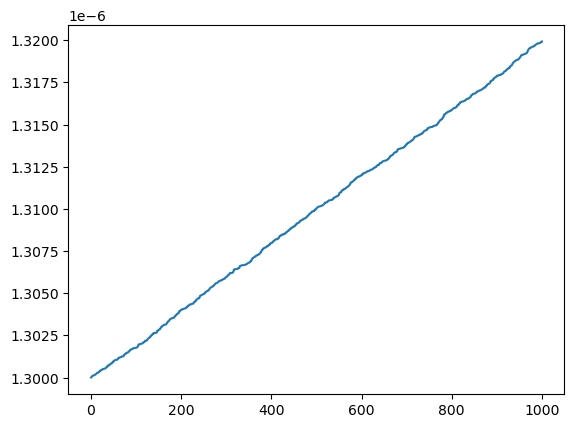

In [19]:
plt.plot(simple_mux_tf["laser_wavelength"].flatten())

In [20]:
ebmux_output_power_tbk_sweep.shape

(501, 7)

In [21]:
simple_mux_tf["laser_wavelength"].shape

(1, 1001, 1, 1)

In [22]:
simple_mux_tf["ilmux"][0,np.argmin(np.abs(simple_mux_tf["laser_wavelength"]- output_wavelength_tbk_value)), idd_no,0]

0.00013564296000065942

In [23]:
output_wavelength_tbk_sweep.shape

(501, 7)

In [24]:
simple_mux_tf["ildemux"].shape

(1, 1001, 501, 1)

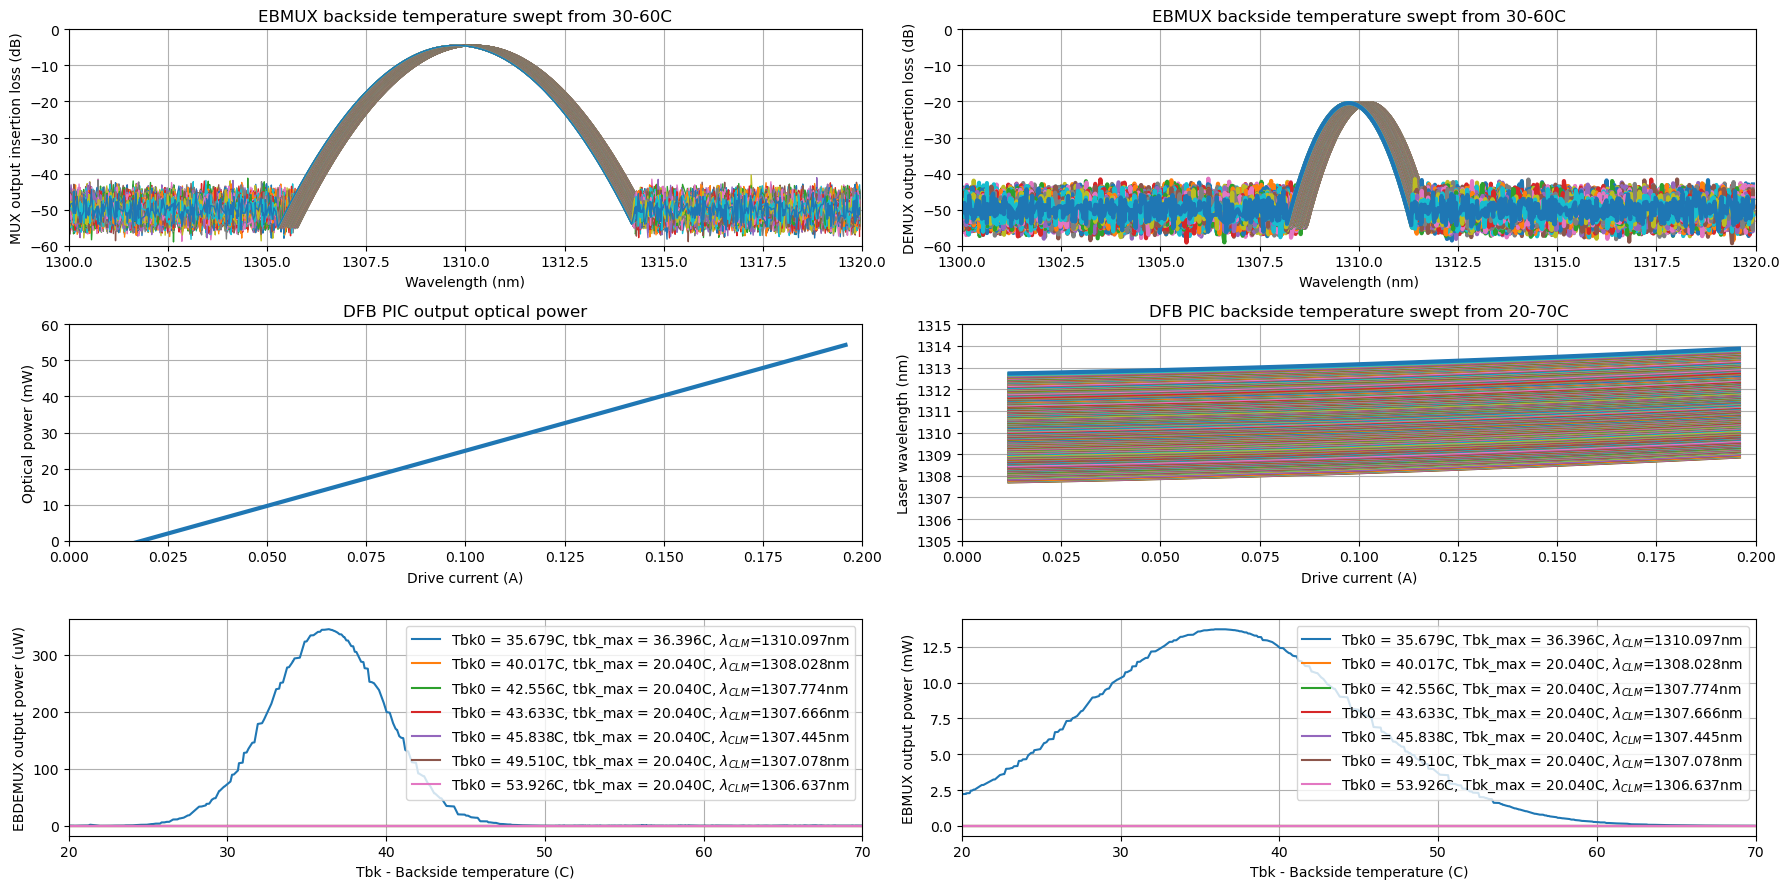

In [25]:
plt.figure(figsize=(18,9))
plt.subplot(321)
for idd_no in range(temperature_datapoints):
    plt.plot(simple_mux_tf["laser_wavelength"].flatten()*1e9, 10*np.log10(simple_mux_tf["ilmux"][:,:,idd_no].flatten()), linewidth=1.0)
plt.xlim([1300, 1320])
plt.ylim([-60, 0])
plt.xlabel("Wavelength (nm)")
plt.ylabel("MUX output insertion loss (dB)")
plt.title("EBMUX backside temperature swept from 30-60C")
plt.grid(True)
plt.subplot(322)
for idd_no in range(temperature_datapoints):
    plt.plot(simple_mux_tf["laser_wavelength"].flatten()*1e9, 10*np.log10(simple_mux_tf["ildemux"][:,:,idd_no].flatten()), linewidth=3.0)
plt.xlim([1300, 1320])
plt.ylim([-60, 0])
plt.xlabel("Wavelength (nm)")
plt.ylabel("DEMUX output insertion loss (dB)")
plt.title("EBMUX backside temperature swept from 30-60C")
plt.grid(True)
plt.subplot(323)
plt.plot(simple_laser_tf["i_drive"].flatten(), simple_laser_tf["opt_power"].flatten()*1e3, linewidth=3.0)
plt.xlabel("Drive current (A)")
plt.ylabel("Optical power (mW)")
plt.title("DFB PIC output optical power")
plt.xlim([0.0, 0.2])
plt.ylim([0, 60])
plt.grid(True)
plt.subplot(324)
for idd_no in range(temperature_datapoints):
    plt.plot(simple_laser_tf["i_drive"].flatten(), simple_laser_tf["delta_lambda"][:,:, idd_no, 0].flatten()*1e9 + laser_center_wavelength*1e9, linewidth=3.0)
plt.xlabel("Drive current (A)")
plt.ylabel("Laser wavelength (nm)")
plt.title("DFB PIC backside temperature swept from 20-70C")
plt.xlim([0.0, 0.2])
plt.ylim([1305, 1315])
plt.yticks(np.arange(1305, 1316, 1))
plt.grid(True)
plt.subplot(325)
for idd_tbk0, tbk0_value in enumerate(tbk0[0,0,0,:]):
    plt.plot(tbk.flatten(), ebdemux_output_power_tbk_sweep[:, idd_tbk0]*1e6, label="Tbk0 = "+f"{tbk0[0,0,0,idd_tbk0]:0.3f}"+"C, tbk_max = "+f"{tbk[0,0,np.argmax(ebdemux_output_power_tbk_sweep[:, idd_tbk0]),0]:0.3f}"+r"C, $\lambda_{CLM}$="+f"{output_wavelength_tbk_sweep[np.argmax(ebdemux_output_power_tbk_sweep[:, idd_tbk0]), idd_tbk0]*1e9:0.3f}nm")
plt.legend()
plt.grid(True)
plt.xlim([min_temperature_sweep, max_temperature_sweep])
# plt.ylim([0, 500])
plt.xlabel("Tbk - Backside temperature (C)")
plt.ylabel("EBDEMUX output power (uW)")
plt.subplot(326)
for idd_tbk0, tbk0_value in enumerate(tbk0[0,0,0,:]):
    plt.plot(tbk.flatten(), ebmux_output_power_tbk_sweep[:, idd_tbk0]*1e3, label="Tbk0 = "+f"{tbk0[0,0,0,idd_tbk0]:0.3f}"+"C, Tbk_max = "+f"{tbk[0,0,np.argmax(ebdemux_output_power_tbk_sweep[:, idd_tbk0]),0]:0.3f}"+r"C, $\lambda_{CLM}$="+f"{output_wavelength_tbk_sweep[np.argmax(ebdemux_output_power_tbk_sweep[:, idd_tbk0]), idd_tbk0]*1e9:0.3f}nm")
plt.legend()
plt.grid(True)
plt.xlim([min_temperature_sweep, max_temperature_sweep])
# plt.ylim([0, 20])
plt.xlabel("Tbk - Backside temperature (C)")
plt.ylabel("EBMUX output power (mW)")
plt.tight_layout()